In [2]:
#@ Initializiimport torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster

In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir='P1_Facial_Keypoints/training/'
all_img_paths=glob.glob(os.path.join(root_dir, '*.jpg'))
data=pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038 (from 1)
Receiving objects: 100% (6049/6049), 329.53 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [5]:
data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,...,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,...,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,...,122.0,169.0,133.0,169.0,122.0,172.0,115.0,172.0,111.0,172.0
3460,Erin_Hershey_Presley_41.jpg,82.0,91.0,82.0,105.0,82.0,116.0,86.0,128.0,90.0,...,119.0,132.0,134.0,136.0,119.0,139.0,112.0,139.0,108.0,139.0


In [6]:
class FacesData(Dataset):
  def __init__(self, df):
    super(FacesData).__init__()
    self.df=df
    self.normalize=transforms.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])

  def __len__(self): return len(self.df)

  def __getitem__(self, ix):
    img_path='P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
    img=cv2.imread(img_path)/255
    kp=deepcopy(self.df.iloc[ix, 1:].tolist())
    kp_x=(np.array(kp[0::2])/img.shape[1]).tolist()
    kp_y=(np.array(kp[1::2])/img.shape[0]).tolist()
    kp2=kp_x + kp_y
    kp2=torch.tensor(kp2)
    img=self.preprocess_input(img)
    return img, kp2

  def preprocess_input(self, img):
    img=cv2.resize(img, (224, 224))
    img=torch.tensor(img).permute(2, 0, 1)
    img=self.normalize(img).float()
    return img.to(device)

  def load_img(self, ix):
    img_path='P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
    img=cv2.resize(img, (224, 224))
    return img


In [7]:
from sklearn.model_selection import train_test_split

train, test=train_test_split(data, test_size=0.2, random_state=42)
train_dataset=FacesData(train.reset_index(drop=True))
test_dataset=FacesData(test.reset_index(drop=True))

train_loader=DataLoader(train_dataset, batch_size=32)
test_loader=DataLoader(test_dataset, batch_size=32)

In [8]:
#@ Model for levaraging keypoints on images:
def get_model():
  model=models.vgg16(weights=True)
  for param in model.parameters():
    param.requires_grad=False

    model.avgpool=nn.Sequential(nn.Conv2d(512, 512, 3),
                                nn.MaxPool2d(2),
                                nn.Flatten())

    model.classifier=nn.Sequential(
                      nn.Linear(2048, 512),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(512, 136),
                      nn.Sigmoid()
    )

    criterion=nn.L1Loss() #mean absolute error
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), criterion, optimizer

In [9]:
model, criterion, optimizer=get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.3MB/s]


In [10]:
def train_batch(img, kps, model, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  _kps=model(img.to(device))
  loss=criterion(_kps, kps.to(device))
  loss.backward()
  optimizer.step()
  return loss

In [11]:
#@ Building a fucntion that returns the loss on the test data and the predicted keypoints:
@torch.no_grad()
def validate_batch(img, kps, model, criterion):
  model.eval()
  _kps=model(img.to(device))
  loss=criterion(_kps, kps.to(device))
  return _kps, loss

In [17]:
train_loss, test_loss = [], []
n_epochs = 20

for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} : 20")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 epoch 1 : 20
 epoch 2 : 20
 epoch 3 : 20
 epoch 4 : 20
 epoch 5 : 20
 epoch 6 : 20
 epoch 7 : 20
 epoch 8 : 20
 epoch 9 : 20
 epoch 10 : 20
 epoch 11 : 20
 epoch 12 : 20
 epoch 13 : 20
 epoch 14 : 20
 epoch 15 : 20
 epoch 16 : 20
 epoch 17 : 20
 epoch 18 : 20
 epoch 19 : 20
 epoch 20 : 20


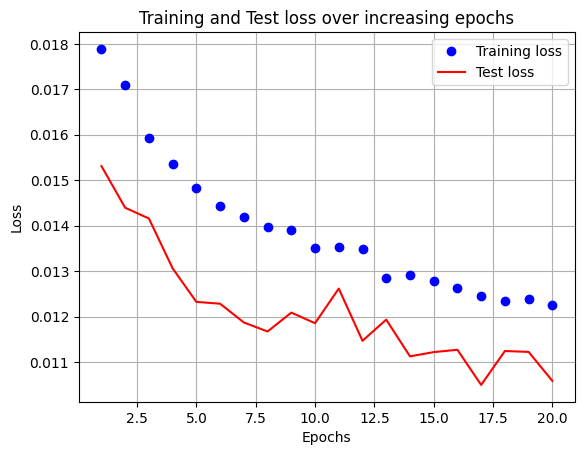

In [18]:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

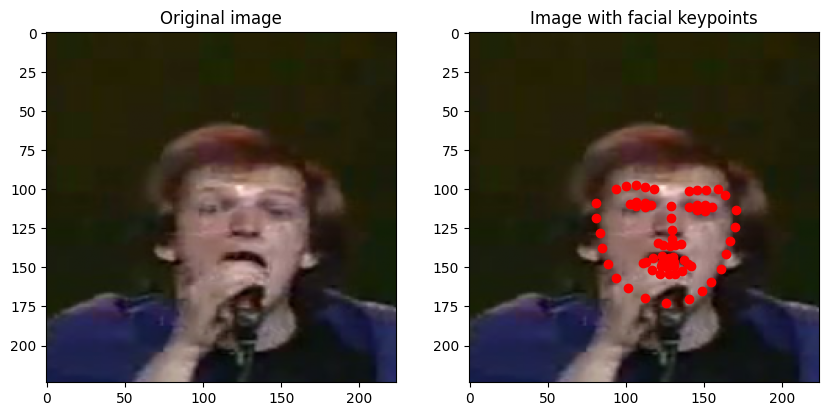

In [19]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()